In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from algorithms import algos
from DataPrep import DataPrep

In [2]:
channels = [1,2,3,4]
baseline_fraction = 0.3
ref_ch = 1
cfd_fraction = 0.4
infile = '../data/source_coincidence_test10_Aug22.h5'
amplitudeLimits = {1:(0.1,0.65), 2:(0.1,0.65), 3:(0.1,0.65), 4:(0.1,0.65)}

smooth=False
kernel_sigma=1
kernel_width=5*kernel_sigma

In [3]:
dp = DataPrep(infile)
ch = 1
dp.prepAndCalculate(ch)
cfds = dp.getCFDtimes()

CFD fraction: 0.4 baseline fraction: 0.3


Text(0.5, 0, 'time')

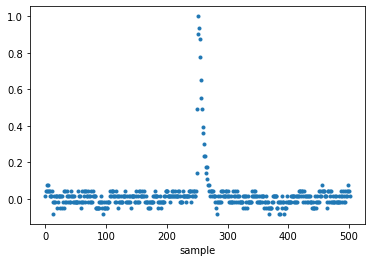

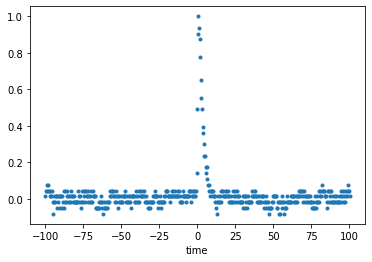

In [5]:
wfs = dp.getWaveforms()
plt.plot(wfs[0],marker='.',linestyle='None')
plt.xlabel("sample")

time = dp.getTimeAxis()
plt.figure()
plt.plot(time,wfs[0],marker='.',linestyle='None')
plt.xlabel("time")

In [5]:
cfds[0]
len(cfds)

9138

In [12]:
f = h5py.File(infile,'r')

num_triggers = len(f['ch1_samples'])
print(num_triggers)
# num_triggers = 10000
num_samples = len(f['ch1_samples'][0])
time_begin = f['ch1_trig_offset'][0]*1e9
time_end = f['ch1_horiz_scale'][0]*(num_samples-1)*1e9+time_begin
time = np.linspace(time_begin, time_end, num_samples)
sampling_freq = num_samples/(time_end-time_begin)
print(sampling_freq)

10000
2.504989986514876


In [13]:
amplitudes = {}
amplitudesSelected = {}
cfd_times = {}
noise = {}
riseTime = {}

In [32]:
for channel in channels:
    temp_cfd = []
    temp_amp = []
    temp_amp_selected = []
    temp_noise = []
    temp_riseTime = []
    samples = f[f'ch{channel}_samples']
    horiz_scale = f[f'ch{channel}_horiz_scale']
    trig_offset = f[f'ch{channel}_trig_offset']
    for trig in range(num_triggers):
        waveform = samples[trig]
        baseline_n = int(len(waveform)*baseline_fraction)
        waveform = np.mean(waveform[:baseline_n]) - waveform
        a = algos(waveform)
        temp_noise.append(np.std(waveform[:baseline_n]))
        amp = np.max(waveform)
        temp_amp.append(amp)
        
        if amp>amplitudeLimits[channel][0] and amp<amplitudeLimits[channel][1]:
            #cfd_val = cfd(waveform, threshold=amplitudeLimits[channel][0], base_line=baseline_n, fraction=cfd_fraction, smooth=smooth, kernel_width=kernel_width, kernel_sigma=kernel_sigma)
            cfd_val = a.cfd(threshold=amplitudeLimits[channel][0],base_line = baseline_n, fraction=cfd_fraction, smooth=smooth, kernel_width=kernel_width, kernel_sigma=kernel_sigma)
            if cfd_val is not None:
                temp_cfd.append((cfd_val*horiz_scale[trig]+trig_offset[trig])*1e9)
                temp_amp_selected.append(amp)
                if channel == 1 and trig == 0:
                    print((cfd_val*horiz_scale[trig]+trig_offset[trig])*1e9)
            else:
                temp_cfd.append(-900)
            # Rise time:
            #cfd_rt20 = cfd(waveform, threshold=amplitudeLimits[channel][0], base_line=baseline_n, fraction=0.2, smooth=False)
            #cfd_rt80 = cfd(waveform, threshold=amplitudeLimits[channel][0], base_line=baseline_n, fraction=0.8, smooth=False)
            cfd_rt20 = a.cfd(threshold=amplitudeLimits[channel][0], base_line=baseline_n, fraction=0.2, smooth=False)
            cfd_rt80 = a.cfd(threshold=amplitudeLimits[channel][0], base_line=baseline_n, fraction=0.8, smooth=False)
            if cfd_rt20 is not None and cfd_rt80 is not None:
                temp_riseTime.append( (cfd_rt80-cfd_rt20)*horiz_scale[trig]*1e9 )
            else:
                temp_riseTime.append(-900)
            
        else:
            temp_cfd.append(-900)
            temp_riseTime.append(-900)
            
    cfd_times[channel] = np.array(temp_cfd)
    amplitudes[channel] = np.array(temp_amp)
    amplitudesSelected[channel] = np.array(temp_amp_selected)
    noise[channel] = np.array(temp_noise)
    riseTime[channel] = np.array(temp_riseTime)

-0.1828447237782042


cfd_val: 249.74 cfd_val_adj: -0.1828447237782042
horiz_scale: 4.000000053405728e-10 trig_offset: -1.0007884605753285e-07
sampling frequency: 2.504989986514876


Text(0.5, 0, 'sample')

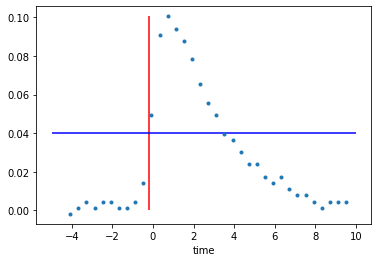

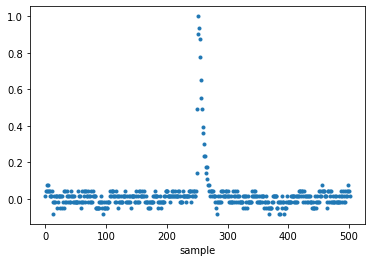

In [75]:
channel = 1
samples = f[f'ch{channel}_samples']
horiz_scale = f[f'ch{channel}_horiz_scale']
trig_offset = f[f'ch{channel}_trig_offset']

trig = 0
waveform = samples[trig]
baseline_n = int(len(waveform)*baseline_fraction)
waveform = np.mean(waveform[:baseline_n]) - waveform
a = algos(waveform)
temp_noise.append(np.std(waveform[:baseline_n]))
amp = np.max(waveform)


plot_samples_begin = 240
plot_samples_end = 275
plot_num_samples = plot_samples_end - plot_samples_begin

plt.plot(time[plot_samples_begin:plot_samples_end],waveform[plot_samples_begin:plot_samples_end],marker='.',linestyle='None')
plt.xlabel("time")


if amp>amplitudeLimits[channel][0] and amp<amplitudeLimits[channel][1]:
    #cfd_val = cfd(waveform, threshold=amplitudeLimits[channel][0], base_line=baseline_n, fraction=cfd_fraction, smooth=smooth, kernel_width=kernel_width, kernel_sigma=kernel_sigma)
    cfd_val = a.cfd(threshold=amplitudeLimits[channel][0],base_line = baseline_n, fraction=cfd_fraction, smooth=smooth, kernel_width=kernel_width, kernel_sigma=kernel_sigma)
    cfd_val_adj = (cfd_val*horiz_scale[trig]+trig_offset[trig])*1e9
    if cfd_val is not None:
        print("cfd_val:",cfd_val,"cfd_val_adj:",cfd_val_adj)
        print("horiz_scale:",horiz_scale[trig],"trig_offset:",trig_offset[trig])

print("sampling frequency:",sampling_freq)           
plt.vlines(cfd_val_adj,0,amp, color='red') 
plt.hlines(cfd_fraction*amp,-5,10, color='blue')
plt.figure()
plt.plot(waveform,marker='.',linestyle='None')
plt.xlabel("sample")
                
                